# Housing Data Analysis

### Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Function to Fetch Housing Data

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

### Load Data

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


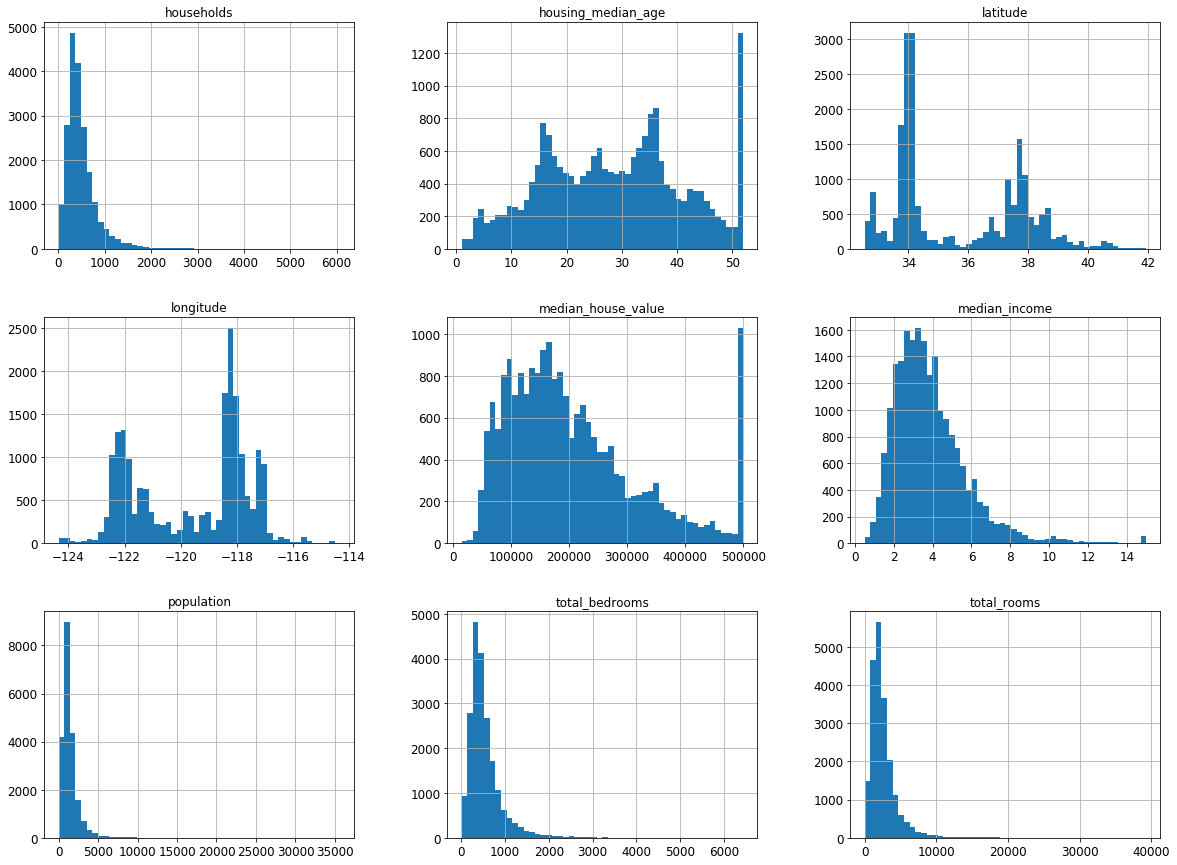

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Create a Test Set

In [10]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), " train data, ", len(test_set), " test data")

16512  train data,  4128  test data


In [12]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [14]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [15]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [17]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


In [18]:
print(len(train_set), " train data, ", len(test_set), " test data")

16512  train data,  4128  test data


### Create a Test Set with Stratified Sampling

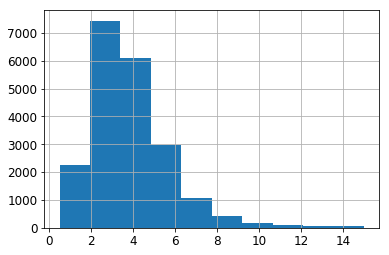

In [19]:
housing["median_income"].hist()

In [20]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [21]:

housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [23]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [24]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [25]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [26]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


In [27]:

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Visualizing Data

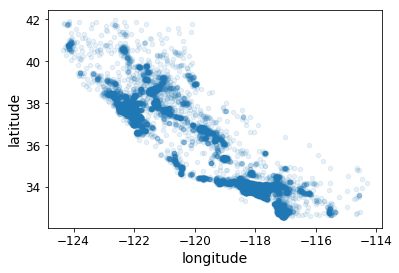

In [28]:
housing = strat_train_set.copy()

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

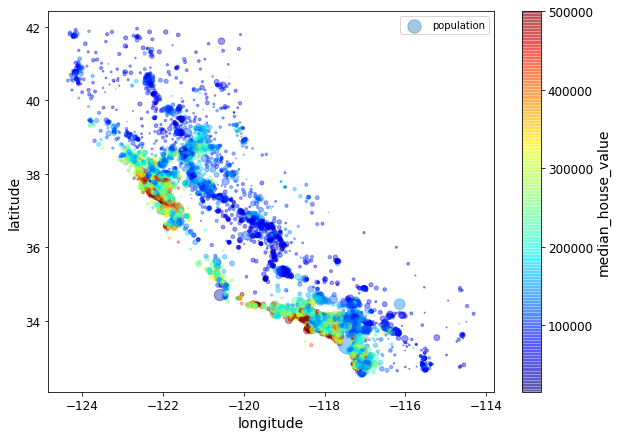

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

### Finding Correlations

In [30]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a643898>,
      dtype=object)

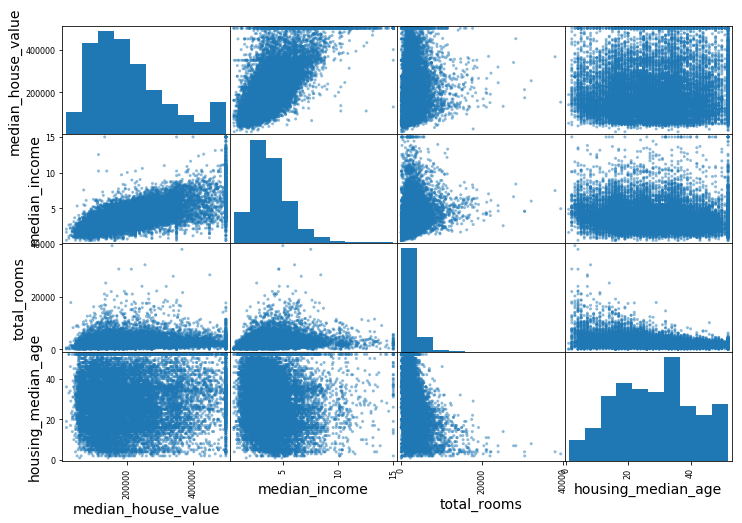

In [31]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

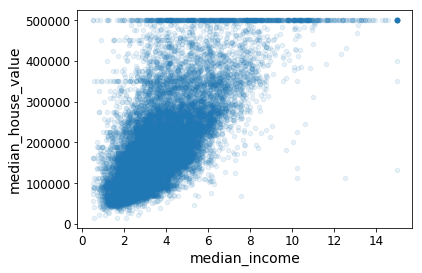

In [32]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

### Making New Attributes

In [33]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]


In [34]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Preparing Data for Machine Learning Algorithms

In [35]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

In [36]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

In [37]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [38]:
imputer.fit(housing_num)
imputer.statistics_


array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [39]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [40]:
housing_cat = housing['ocean_proximity']
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [41]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [42]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [43]:
#from sklearn.preprocessing import CategoricalEncoder # in future versions of Scikit-Learn

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [45]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [46]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [49]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [50]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [51]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [52]:
housing_prepared.shape

(16512, 16)

### Select and Train a Model

In [53]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

//anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [54]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849878]


In [55]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [56]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [57]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001896

In [58]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [59]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_predictions, housing_labels)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Evaluate with Cross-Validation

In [60]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [61]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [69316.02634772 65498.84994772 71404.25935862 69098.46240168
 70580.30735263 75540.88413124 69717.93143674 70428.42648461
 75888.17618283 68976.12268448]
Mean: 70644.94463282847
Standard Deviation: 2938.9378926251234


In [62]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [63]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21941.911027380233

In [64]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

In [65]:
display_scores(forest_rmse_scores)

Scores: [51650.94405471 48920.80645498 52979.16096752 54412.74042021
 50861.29381163 56488.55699727 51866.90120786 49752.24599537
 55399.50713191 53309.74548294]
Mean: 52564.19025244012
Standard Deviation: 2301.873803919754


In [66]:
# from sklearn.neural_network import MLPRegressor

# nn_reg = MLPRegressor(hidden_layer_sizes=(20,20,20), learning_rate_init=0.003, max_iter=1000)
# nn_reg.fit(housing_prepared, housing_labels)

In [67]:
# housing_predictions = nn_reg.predict(housing_prepared)
# nn_mse = mean_squared_error(housing_labels, housing_predictions)
# nn_rmse = np.sqrt(nn_mse)
# nn_rmse

In [68]:
# scores = cross_val_score(nn_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
# nn_rmse_scores = np.sqrt(-scores)
# display_scores(nn_rmse_scores)

In [69]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'bootstrap': [False], 'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [70]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [71]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [72]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63647.85444595992 {'max_features': 2, 'n_estimators': 3}
55611.50159876327 {'max_features': 2, 'n_estimators': 10}
53370.06407363344 {'max_features': 2, 'n_estimators': 30}
60959.138858487866 {'max_features': 4, 'n_estimators': 3}
52740.58416665252 {'max_features': 4, 'n_estimators': 10}
50374.14214614731 {'max_features': 4, 'n_estimators': 30}
58661.2866461823 {'max_features': 6, 'n_estimators': 3}
52009.973979776936 {'max_features': 6, 'n_estimators': 10}
50154.11777368494 {'max_features': 6, 'n_estimators': 30}
57865.36168014446 {'max_features': 8, 'n_estimators': 3}
51730.07550866553 {'max_features': 8, 'n_estimators': 10}
49694.85143334442 {'max_features': 8, 'n_estimators': 30}
62874.407393096284 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54643.49980834466 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59437.89228588419 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52735.358293621044 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [73]:
pd.DataFrame(cvres)

//anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
//anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
//anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
//anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:1

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.116513,0.009010,-4.051049e+09,-1.106013e+09,NaN,2,3,"{'max_features': 2, 'n_estimators': 3}",18,-3.850668e+09,...,-4.194135e+09,-1.116843e+09,-3.906732e+09,-1.112813e+09,-4.169669e+09,-1.129842e+09,0.080302,0.008085,1.431223e+08,2.173798e+07
1,0.242600,0.011574,-3.092639e+09,-5.819353e+08,NaN,2,10,"{'max_features': 2, 'n_estimators': 10}",11,-3.052380e+09,...,-3.124982e+09,-5.780873e+08,-2.865117e+09,-5.713421e+08,-3.169914e+09,-5.797944e+08,0.013431,0.000697,1.306954e+08,7.584886e+06
2,0.784575,0.035828,-2.848364e+09,-4.396234e+08,NaN,2,30,"{'max_features': 2, 'n_estimators': 30}",9,-2.692176e+09,...,-2.943808e+09,-4.374429e+08,-2.619893e+09,-4.374715e+08,-2.968460e+09,-4.451903e+08,0.048009,0.002267,1.604534e+08,2.883885e+06
3,0.115768,0.003971,-3.716017e+09,-9.850011e+08,NaN,4,3,"{'max_features': 4, 'n_estimators': 3}",16,-3.729600e+09,...,-3.736527e+09,-9.172986e+08,-3.404974e+09,-1.035901e+09,-3.914186e+09,-9.711998e+08,0.002096,0.000471,1.690029e+08,4.047487e+07
4,0.399048,0.012448,-2.781569e+09,-5.160154e+08,NaN,4,10,"{'max_features': 4, 'n_estimators': 10}",8,-2.667093e+09,...,-2.891599e+09,-4.960301e+08,-2.613393e+09,-5.422542e+08,-2.949550e+09,-5.158794e+08,0.011078,0.001182,1.278498e+08,1.498960e+07
5,1.239483,0.032518,-2.537554e+09,-3.878685e+08,NaN,4,30,"{'max_features': 4, 'n_estimators': 30}",3,-2.387199e+09,...,-2.663178e+09,-3.789712e+08,-2.397951e+09,-4.036920e+08,-2.649850e+09,-3.846171e+08,0.085142,0.005168,1.209935e+08,8.424973e+06
6,0.160362,0.003972,-3.441147e+09,-9.030212e+08,NaN,6,3,"{'max_features': 6, 'n_estimators': 3}",14,-3.119576e+09,...,-3.587747e+09,-9.360639e+08,-3.331544e+09,-9.025026e+08,-3.577062e+09,-8.612945e+08,0.003762,0.000058,1.884229e+08,2.639683e+07
7,0.541498,0.012147,-2.705037e+09,-5.014210e+08,NaN,6,10,"{'max_features': 6, 'n_estimators': 10}",6,-2.553481e+09,...,-2.762945e+09,-4.996537e+08,-2.519522e+09,-4.989516e+08,-2.906270e+09,-5.063617e+08,0.014445,0.001397,1.464963e+08,3.357661e+06
8,1.681414,0.035775,-2.515436e+09,-3.840197e+08,NaN,6,30,"{'max_features': 6, 'n_estimators': 30}",2,-2.371924e+09,...,-2.607962e+09,-3.805596e+08,-2.351220e+09,-3.856159e+08,-2.662399e+09,-3.904866e+08,0.056573,0.005049,1.283580e+08,3.796810e+06
9,0.219858,0.004228,-3.348400e+09,-8.884890e+08,NaN,8,3,"{'max_features': 8, 'n_estimators': 3}",13,-3.351347e+09,...,-3.396841e+09,-8.596460e+08,-3.131753e+09,-8.893698e+08,-3.509451e+09,-9.146734e+08,0.008979,0.000160,1.226683e+08,2.730057e+07


In [110]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
forest_rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
forest_rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x115656710>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x115656518>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [111]:
cvres = forest_rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49147.15241724505 {'max_features': 7, 'n_estimators': 180}
51396.876896929905 {'max_features': 5, 'n_estimators': 15}
50797.05737322649 {'max_features': 3, 'n_estimators': 72}
50840.744513982805 {'max_features': 5, 'n_estimators': 21}
49276.17530332962 {'max_features': 7, 'n_estimators': 122}
50775.46331678437 {'max_features': 3, 'n_estimators': 75}
50681.383924974936 {'max_features': 3, 'n_estimators': 88}
49612.152530468346 {'max_features': 5, 'n_estimators': 100}
50473.01751424941 {'max_features': 3, 'n_estimators': 150}
64458.25385034794 {'max_features': 5, 'n_estimators': 2}


In [76]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [77]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [78]:

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

In [80]:
final_model = forest_rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [81]:
final_rmse

46921.659310064526

### Full Pipeline with Predictor

In [82]:

full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849878])

In [83]:
my_model = full_pipeline_with_predictor

from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

In [84]:
my_model_loaded

Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('...ts=None)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

### Extra Exercises


Question: Try a Support Vector Machine regressor (sklearn.svm.SVR), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
        {'kernel': ['linear'], 'C': [1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] kernel=linear, C=1000.0 .........................................
[CV] kernel=linear, C=1000.0 .........................................
[CV] kernel=linear, C=1000.0 .........................................
[CV] kernel=linear, C=1000.0 .........................................
[CV] .......................... kernel=linear, C=1000.0, total=  27.6s
[CV] kernel=linear, C=1000.0 .........................................
[CV] .......................... kernel=linear, C=1000.0, total=  27.6s
[CV] kernel=linear, C=3000.0 .........................................
[CV] .......................... kernel=linear, C=1000.0, total=  28.2s
[CV] kernel=linear, C=3000.0 .........................................
[CV] .......................... kernel=linear, C=1000.0, total=  28.2s
[CV] kernel=linear, C=3000.0 .........................................
[CV] .......................... kernel=linear, C=1000.0, total=  25.1s
[CV] kernel=lin

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  7.1min


[CV] ..................... kernel=rbf, gamma=3.0, C=1.0, total=  30.5s
[CV] kernel=rbf, gamma=0.3, C=3.0 ....................................
[CV] ..................... kernel=rbf, gamma=3.0, C=1.0, total=  31.2s
[CV] kernel=rbf, gamma=0.3, C=3.0 ....................................
[CV] ..................... kernel=rbf, gamma=0.3, C=3.0, total=  27.9s
[CV] kernel=rbf, gamma=0.3, C=3.0 ....................................
[CV] ..................... kernel=rbf, gamma=0.3, C=3.0, total=  30.0s
[CV] kernel=rbf, gamma=1.0, C=3.0 ....................................
[CV] ..................... kernel=rbf, gamma=0.3, C=3.0, total=  29.8s
[CV] kernel=rbf, gamma=1.0, C=3.0 ....................................
[CV] ..................... kernel=rbf, gamma=0.3, C=3.0, total=  30.5s
[CV] kernel=rbf, gamma=1.0, C=3.0 ....................................
[CV] ..................... kernel=rbf, gamma=0.3, C=3.0, total=  29.0s
[CV] kernel=rbf, gamma=1.0, C=3.0 ....................................
[CV] .

[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 24.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [1000.0, 3000.0, 10000.0, 30000.0]}, {'kernel': ['rbf'], 'gamma': [0.3, 1.0, 3.0], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [90]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.90313964167

In [91]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

Question: Try replacing GridSearchCV with RandomizedSearchCV.

In [92]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy-0.19.0/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] kernel=linear, gamma=3.010121430917521, C=629.782329591372 ......
[CV] kernel=linear, gamma=3.010121430917521, C=629.782329591372 ......
[CV] kernel=linear, gamma=3.010121430917521, C=629.782329591372 ......
[CV] kernel=linear, gamma=3.010121430917521, C=629.782329591372 ......
[CV]  kernel=linear, gamma=3.010121430917521, C=629.782329591372, total=  36.3s
[CV]  kernel=linear, gamma=3.010121430917521, C=629.782329591372, total=  36.3s
[CV] kernel=linear, gamma=3.010121430917521, C=629.782329591372 ......
[CV] kernel=rbf, gamma=0.9084469696321253, C=26290.206464300216 ......
[CV]  kernel=linear, gamma=3.010121430917521, C=629.782329591372, total=  36.3s
[CV]  kernel=linear, gamma=3.010121430917521, C=629.782329591372, total=  36.3s
[CV] kernel=rbf, gamma=0.9084469696321253, C=26290.206464300216 ......
[CV] kernel=rbf, gamma=0.9084469696321253, C=26290.206464300216 ......
[CV]  kernel=linear, gamma=3.010121430917521, C=62

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  5.5min


[CV]  kernel=rbf, gamma=0.3627537294604771, C=108.30488238805073, total=  22.1s
[CV] kernel=linear, gamma=0.023332523598323388, C=21.344953672647435 .
[CV]  kernel=rbf, gamma=0.3627537294604771, C=108.30488238805073, total=  22.0s
[CV] kernel=linear, gamma=0.023332523598323388, C=21.344953672647435 .
[CV]  kernel=rbf, gamma=0.3627537294604771, C=108.30488238805073, total=  21.5s
[CV] kernel=linear, gamma=0.023332523598323388, C=21.344953672647435 .
[CV]  kernel=linear, gamma=0.023332523598323388, C=21.344953672647435, total=  18.1s
[CV] kernel=rbf, gamma=0.15023452872733867, C=5603.270317432516 ......
[CV]  kernel=linear, gamma=0.023332523598323388, C=21.344953672647435, total=  17.7s
[CV] kernel=rbf, gamma=0.15023452872733867, C=5603.270317432516 ......
[CV]  kernel=linear, gamma=0.023332523598323388, C=21.344953672647435, total=  17.3s
[CV] kernel=rbf, gamma=0.15023452872733867, C=5603.270317432516 ......
[CV]  kernel=linear, gamma=0.023332523598323388, C=21.344953672647435, total=  

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 45.1min


[CV]  kernel=linear, gamma=1.4752145260435134, C=16483.850529752886, total=  27.9s
[CV] kernel=rbf, gamma=1.052904084582266, C=101445.66881340064 .......
[CV]  kernel=rbf, gamma=1.052904084582266, C=101445.66881340064, total= 2.0min
[CV] kernel=rbf, gamma=1.052904084582266, C=101445.66881340064 .......
[CV]  kernel=rbf, gamma=1.052904084582266, C=101445.66881340064, total= 1.9min
[CV] kernel=rbf, gamma=0.9763011917123741, C=56681.80859029545 .......
[CV]  kernel=rbf, gamma=1.052904084582266, C=101445.66881340064, total= 2.5min
[CV] kernel=rbf, gamma=0.9763011917123741, C=56681.80859029545 .......
[CV]  kernel=rbf, gamma=1.052904084582266, C=101445.66881340064, total= 2.6min
[CV] kernel=rbf, gamma=0.9763011917123741, C=56681.80859029545 .......
[CV]  kernel=rbf, gamma=0.9763011917123741, C=56681.80859029545, total=  53.7s
[CV] kernel=rbf, gamma=0.9763011917123741, C=56681.80859029545 .......
[CV]  kernel=rbf, gamma=0.9763011917123741, C=56681.80859029545, total=  54.6s
[CV] kernel=rbf, 

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 67.1min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x121b44358>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x121b448d0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [93]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.99053704408

In [94]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [95]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [117]:
k = 7
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [118]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [119]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ]])

In [120]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ]])

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [121]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('forest_reg', RandomForestRegressor(random_state=42, **forest_rnd_search.best_params_))
])


In [122]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('...stimators=180, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False))])

In [125]:
some_data = housing.iloc[:30]
some_labels = housing_labels.iloc[:30]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(prepare_select_and_predict_pipeline.predict(some_data), some_labels)))

Predictions:	 [261700.         342976.11666667 211146.11666667  50361.11111111
 231922.22222222 129411.66666667 496324.82222222 184175.00555556
  97560.55555556 399925.17222222  94233.33333333  67628.88888889
 323640.58888889  96743.33333333 132307.77777778 196318.88888889
 453099.05        68935.55555556 124838.33333333 195891.66666667
 269877.22222222 500001.         176448.33333333 117727.77777778
  59101.62222222 129522.22222222 250075.55555556 107458.88888889
 142933.33333333 459943.40555556]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0, 127900.0, 500001.0, 140200.0, 95000.0, 500001.0, 92100.0, 61500.0, 313000.0, 89000.0, 123900.0, 197400.0, 500001.0, 63300.0, 107000.0, 184200.0, 280900.0, 500001.0, 171300.0, 116600.0, 60800.0, 121100.0, 270700.0, 109900.0, 159600.0, 500001.0]
Root Mean Squared Error:	 25057.67090741801


Question: Automatically explore some preparation options using GridSearchCV.

In [126]:
param_grid = [
        {'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': [7, 8, 9, 10]}
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean, total=  31.7s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean, total=  31.8s
[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean, total=  31.8s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean, total=  31.9s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=med

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.5min


[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=mean, total=  29.4s
[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=mean, total=  29.1s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median 
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median, total=  28.6s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median, total=  28.7s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median, total=  28.0s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median, total=  28.5

[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  7.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('...stimators=180, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'feature_selection__k': [7, 8, 9, 10], 'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [127]:
grid_search_prep.best_params_

{'feature_selection__k': 10,
 'preparation__num_pipeline__imputer__strategy': 'mean'}

In [128]:
cvres = grid_search_prep.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50444.89627636776 {'feature_selection__k': 7, 'preparation__num_pipeline__imputer__strategy': 'mean'}
50500.85712375555 {'feature_selection__k': 7, 'preparation__num_pipeline__imputer__strategy': 'median'}
50584.79374832069 {'feature_selection__k': 7, 'preparation__num_pipeline__imputer__strategy': 'most_frequent'}
49601.97981336375 {'feature_selection__k': 8, 'preparation__num_pipeline__imputer__strategy': 'mean'}
49638.5895106465 {'feature_selection__k': 8, 'preparation__num_pipeline__imputer__strategy': 'median'}
49676.74067447886 {'feature_selection__k': 8, 'preparation__num_pipeline__imputer__strategy': 'most_frequent'}
49424.89083074932 {'feature_selection__k': 9, 'preparation__num_pipeline__imputer__strategy': 'mean'}
49549.613976225475 {'feature_selection__k': 9, 'preparation__num_pipeline__imputer__strategy': 'median'}
49497.341809789934 {'feature_selection__k': 9, 'preparation__num_pipeline__imputer__strategy': 'most_frequent'}
49414.737184237805 {'feature_selection__k': 10, 